ECE479ICC LAB 2: Raspberry Pi, TF-Keras, and Face Detection
====================================


## PART I: Raspberry Pi Setup and Basics

### Raspberry Pi Setup

From this lab on, you will apply what you have learned in the lectures to train and deploy a neural network on an edge device, Raspberry Pi 4.

Raspberry Pi 4 is an inexpensive but powerful IoT device. You may review this [report][raspberry_pi_history] to learn more about its story. To start, you need to install the proper operating system, you can refer to this [tutorial][headless_rpi_start]. You can use the official [imager] to prepare your OS, you should use this [image_file][image_link]. If you are at home without a monitor, you can set up the OS with the headless option. 

Please notice that we are using **Raspberry Pi 4**, with **custom OS(provided)**.

Once your RPi can boot into the OS normally, you can enable the VNC and access the desktop environment using your laptop/desktop. You can follow the "Enabling and Connecting over VNC" section of the [tutorial][headless_rpi_start] for this.

Now that you have the desktop environment, follow this [guide][picam_start] to set up your pi-camera. You should be able to take pictures and videos with your camera.

[raspberry_pi_history]:https://www.techrepublic.com/article/inside-the-raspberry-pi-the-story-of-the-35-computer-that-changed-the-world/
[image_link]:https://github.com/google-coral/aiy-maker-kit-tools/releases/download/v20220518/aiy-maker-kit-2022-05-18.img.xz
[imager]:https://www.raspberrypi.com/software/
[headless_rpi_start]: https://www.tomshardware.com/reviews/raspberry-pi-headless-setup-how-to,6028.html
[rpi_headless]:https://www.raspberrypi.com/documentation/computers/configuration.html#setting-up-a-headless-raspberry-pi
[rpi_ssh]:https://www.raspberrypi.com/documentation/computers/remote-access.html
[picam_start]:https://picamera.readthedocs.io/en/latest/
[headless_setup]:https://www.raspberrypi.org/documentation/remote-access/ssh/

In this part of the lab, you need to complete the following tasks: 

  * Install Raspbian OS in your Raspberry Pi, set up your network connection, and take a selfie on the pi-camera.
  * **Print** the CPU specs with `cat /proc/cpuinfo`
  * **Print** network interface configuration with `ifconfig`
  
  
### TensorFlow Setup on Raspberry Pi 

Once you can log into the Raspberry Pi desktop, please verify to make sure tf_lite is correctly installed in the raspberry pi. 
By running
```Python
import tflite_runtime.interpreter as tflite
```
in a python3 environment. If there is no error, the installation is done.

If error occurs, you can follow the [this_guide][tf_lite_install] and [this_guide][coral_setup] to install **TensorFlow Lite** on your Raspberry Pi and work with the accelerator.

[tf_lite_install]:https://www.tensorflow.org/lite/guide/python
[coral_setup]:https://coral.ai/docs/accelerator/get-started/

### TensorFlow Setup on Your PC

Please follow the following commands in your conda environment to install **TensorFlow 2.10** on your own PC.
```
conda install -c conda-forge tensorflow=2.10
```
If you have a Apple Silicon Mac, please follow this [guide][tf_install]. It is a little more complicated.


After the installation. Please verify that the installation is properly done. By running
```Python
import tensorflow as tf
tf.__version__
```
in a python environment, notice the version number for your Tensorflow.

[tf_install]:https://towardsdatascience.com/installing-tensorflow-on-the-m1-mac-410bb36b776

## PART II: Building and Training with TF-Keras

In part II, you will build a Convolutional Neural Network (CNN) based image classifier. In our lecture, we have introduced CNN, a type of Deep Neural Network (DNN) that features convolutional layers. This [document][cnn_definition] by Stanford CS231n is also a good resource to learn more about CNN. You will build and train a simple CNN with TensorFlow on your own computers.

[cnn_definition]:http://cs231n.github.io/convolutional-networks/

There were two ways to construct and train a neural network model in TF1.x: Keras and low-level APIs. As Tensorflow evolves to 2.x, it leans more toward Keras, a higher-level framework than the previous version's low-level APIs. Keras APIs provide straightforward construction and training of neural networks, which hide away some tedious details of the network. 

Some may argue that low-level APIs provide more precise control over some aspects of the network. While users can still find a way to tune the details by looking deeper into the APIs, the framework encourages them to focus on the big picture and develop better and more robust network models rather than fixating on trivialities. As a beginner, it is helpful for us to start with Keras and establish a basic intuition on how to build and train a simple network.

In this part of the lab, you need to follow this [tutorial][fashion_mnist] to build a neural network to classify the Fashion MNIST dataset.

[fashion_mnist]:https://www.tensorflow.org/tutorials/keras/classification



### FashionNet

You will construct a neural network by yourselves. Let's call it the FashionNet. Here is an overview of the proposed Convolutional Neurual Network (CNN):

![cnn_img](figures/fashionnet.png)

This CNN contains two convolutional layers, two max pooling layers, and three fully connected layers (dense layers). The configuration details of each layer are shown in the following table (in sequential order):

| Layers          | Configuration                        | Activation | Output Dimensions |
|---------------:|--------------------------------------:|-------------------:|----------------------------------------: |
| convolution     | input size = (28, 28, 1), kernel size = (5, 5), stride = 1, padding = 'same'   |       ReLU          |            (28, 28, 4)                     |
| max pooling     | pool_size = (2, 2), stride = 2                           |       -             |            (14, 14, 4)                     |
| convolution     | kernel size = (3, 3), stride = 1, padding = 'valid'|       ReLU          |            (12, 12, 8)                     |
| max pooling     | pool_size = (2, 2), stride = 2                           |       -             |            (6, 6, 8)                       |
| dense |       |       ReLU          |            (128)                     |
| dense |        |       ReLU          |            (64)                      |
| dense |         |       Softmax       |            (10)                      |


### Dataset
In this lab, you will use the Fashion MNIST dataset. You can load the dataset in the following way, which is also shown in the tutorial:
```Python
import tensorflow as tf
from tensorflow import keras
import numpy as np

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
```
As discussed in the lecture, you should only use `train_images` and `train_labels` to train your model. You may also want to validate your model with a training/validation split. We will discuss the details in the next section.

### Build, Train, and Evaluate
Generally, there are three stages in the process of developing a neural network: build, train, and evaluate. In Keras, there are corresponding functions for each stage:

1. **Build** First, you define the model architecture. In this lab, you can use a simple `keras.Sequential` function to define a model, as shown in this [example][sequential]. There are other ways to define a model, but we will not discuss those in this lab. After you have defined your model, you need to tell Keras what you want to do with it by compiling it. In the `model.compile` function, you specify the optimizer, loss function, metrics, and other configurations to prepare for training.
2. **Train** You use `model.fit` function to train your model. In this function, you can specify the training parameters, including batch size, epochs, etc. You should specify your validation split in this function too. Please refer to the document and see how to do that.
3. **Evaluate** After you have trained your model, you need to test the final accuracy using the testing data. The `model.evaluate` function gives you the percentage of the correct results. 

You can find the document for the above functions [here][fit_api].
You may also find that in FashionNet, you use 2-D convolution in the first couple of layers. You may find [this document][layer_api] helpful since the `layers.Conv2D` and `layers.MaxPool2D` functions are not covered in the tutorial.

The training of this CNN should not take a very long time on a laptop/desktop CPU. The final testing accuracy should be higher than 85%, and the training accuracy should be higher than 90%.


### Plot the Training Progress
The `model.fit` function outputs a history of the training metrics (accuracy and loss), including validation metrics. This infomation can be very helpful for diagnosing the model.

**Use `matplotlib` to graph the model accuracy and loss on the training and validation dataset, and include them in your report.** The graph should look something like the following, but yours can be different if you have different configurations of the training process.

![train_img](figures/train.png)

### Saving Your Trained Model
Finally, you will need to save your trained models to model files. Saving a trained model allows you to deploy it to other devices or restore previous training progress at a later time. 

For the purpose of this lab, we ask you to save it using **the TensorFlow SavedModel format**, which will contain the information of the model as well as the weights.

```Python
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
your_trained_model.save("my_model")
```

Please read [this document][save_model] to learn more about how the model save works in tensorflow.

[build_tag]:https://www.tensorflow.org/tutorials/keras/classification#build_the_model
[train_tag]:https://www.tensorflow.org/tutorials/keras/classification#train_the_model
[eval_tag]:https://www.tensorflow.org/tutorials/keras/classification#evaluate_accuracy
[sequential]:https://www.tensorflow.org/guide/keras/sequential_model#when_to_use_a_sequential_model


[fit_api]:https://keras.io/api/models/model_training_apis/
[layer_api]:https://www.tensorflow.org/api_docs/python/tf/keras/layers
[save_model]:https://www.tensorflow.org/guide/keras/save_and_serialize#what_the_savedmodel_contains

In [2]:
# TensorFlow and tf.keras
import os
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.11.0
Num GPUs Available:  0


In [3]:
import tensorflow as tf
import keras
from keras import layers

In [4]:
# TODO:
# 1. Load Fashion MNIST dataset

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(test_labels.shape)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(10000,)


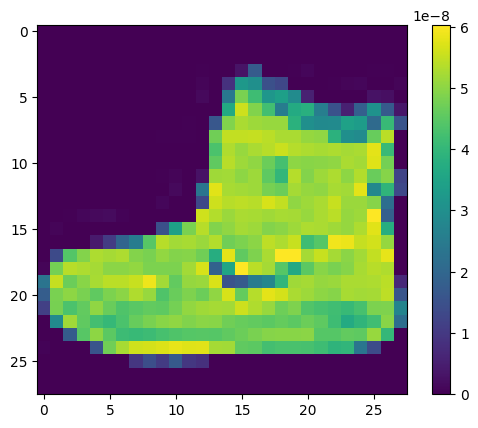

In [51]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

train_images = train_images / 255.0

test_images = test_images / 255.0



In [9]:
# 2. Build, Train, and Evaluate
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(train_images[i], cmap=plt.cm.binary)
#     plt.xlabel(class_names[train_labels[i]])
# plt.show()

In [23]:
# 2. Build, Train, and Evaluate
from tensorflow.keras.optimizers import Adam

# Define the optimizer with the desired learning rate
# Specify your desired learning rate here
model = keras.Sequential([
    # 28X28 greyscale images
    keras.Input(shape=(28, 28, 1)), ##input shape
    layers.Conv2D(4, kernel_size = (5,5), strides=1, padding="same", activation="relu"),
    layers.MaxPooling2D(2, strides=2),
    layers.Conv2D(8, kernel_size = (3,3), strides=1, padding="valid", activation="relu"),
    layers.MaxPooling2D(2, strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
    
])


adam_optimizer = Adam(learning_rate=0.001) 
model.summary()

model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_images, train_labels, batch_size=64, validation_split=0.15, epochs=30)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 4)         104       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 8)         296       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 8)          0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 288)               0         
                                                                 
 dense_21 (Dense)            (None, 128)              

Epoch 1/30
797/797 [==============================] - 7s 8ms/step - loss: 0.5886 - accuracy: 0.7880 - val_loss: 0.4372 - val_accuracy: 0.8413
Epoch 2/30
797/797 [==============================] - 6s 7ms/step - loss: 0.3975 - accuracy: 0.8566 - val_loss: 0.3744 - val_accuracy: 0.8629
Epoch 3/30
797/797 [==============================] - 6s 7ms/step - loss: 0.3493 - accuracy: 0.8716 - val_loss: 0.3533 - val_accuracy: 0.8701
Epoch 4/30
797/797 [==============================] - 6s 7ms/step - loss: 0.3205 - accuracy: 0.8816 - val_loss: 0.3216 - val_accuracy: 0.8842
Epoch 5/30
797/797 [==============================] - 6s 7ms/step - loss: 0.2969 - accuracy: 0.8904 - val_loss: 0.3285 - val_accuracy: 0.8764
Epoch 6/30
797/797 [==============================] - 6s 8ms/step - loss: 0.2809 - accuracy: 0.8962 - val_loss: 0.3295 - val_accuracy: 0.8812
Epoch 7/30
797/797 [==============================] - 6s 8ms/step - loss: 0.2667 - accuracy: 0.9010 - val_loss: 0.3018 - val_accuracy: 0.8847
Epoch 

In [24]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('Test accuracy:', test_acc)

313/313 - 1s - loss: 0.4169 - accuracy: 0.8953 - 728ms/epoch - 2ms/step
Test accuracy: 0.8952999711036682


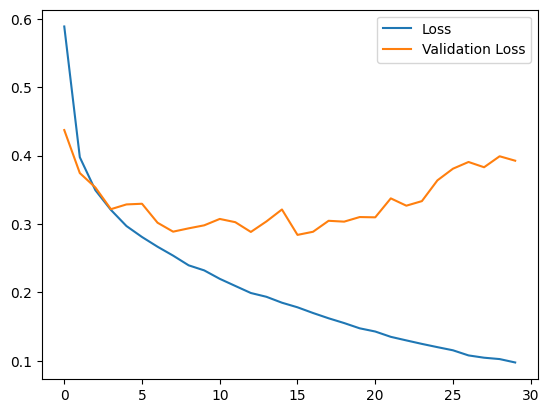

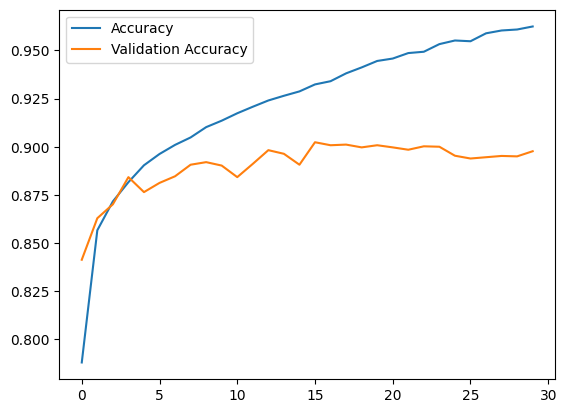

In [25]:

loss = np.array(hist.history['loss'])
acc = np.array(hist.history['accuracy'])
val_loss = np.array(hist.history['val_loss'])
val_acc = np.array(hist.history['val_accuracy'])
plt.figure()
plt.plot(loss, label="Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.show()
plt.plot(acc, label="Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.show()


In [26]:
# 3. Save your model
model.save("Fashion_net")

INFO:tensorflow:Assets written to: Fashion_net\assets


INFO:tensorflow:Assets written to: Fashion_net\assets


In [39]:
##prediction
predictions = model.predict(test_images)


313/313 [==============================] - 1s 2ms/step


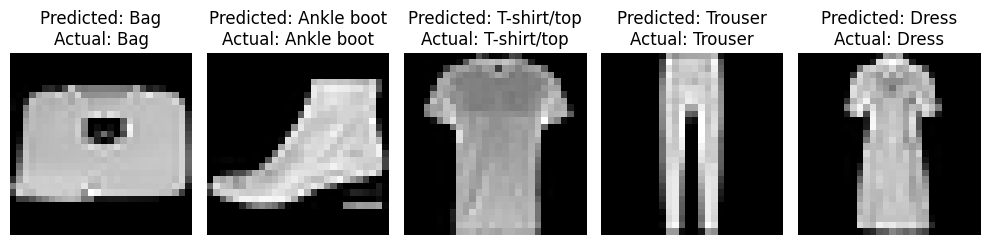

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming model_predictions is an array of predicted labels for test_images
# and test_labels are the actual labels

# Plot some random images along with their predicted and actual labels
num_images_to_plot = 5
random_indices = np.random.choice(len(test_images), size=num_images_to_plot, replace=False)

plt.figure(figsize=(10, 5))

for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images_to_plot, i+1)
    plt.imshow(test_images[idx], cmap='gray')
    predicted_label = np.argmax(predictions[idx])
    actual_label = test_labels[idx]
    plt.title(f'Predicted: {class_names[predicted_label]}\nActual: {class_names[actual_label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Convert Your Trained Model to TFLite model

Before you start the migration process of your trained model onto our edge devices, Raspberry Pi 4, please make sure you have followed the previous steps carefully and have a properly trained TF model with reasonable accuracy on the validation dataset.

Now, locate the directory where your trained model files are saved and create a TFLite converter ready for the next step. 

Please refer to [this document][tf_lite_converter] for more information on the TFLite model.

[tf_lite_converter]:https://www.tensorflow.org/lite/api_docs/python/tf/lite/TFLiteConverter#from_saved_model

In [27]:
# TODO: Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('Fashion_net')

### Optimize your TFLite model with post-trainning quantization
With the converter, we can directly transform our model to TFLite model; however, edge and IoT devices are usually low-powered and relatively lack computational power compared to PC. Therefore, to further enhance the performance, you can apply the post-training quantization technique before deploying the model onto the Raspberry Pi.

Notice that, although the post-training quantization is similar to the quantization and retrain technique that we will introduce in Lecture 12, since the model will not be retrained after the quantization, the impact on the accuracy of the model is usually larger.

In this part, you will need to apply two quantization methods, namely, **Dynamic range quantization** and **Full integer quantization**, listed in [this document][post-trainning quantization] to your pre-trained models and compare the accuracy and performance.

1) For dynamic range quantization, quantization parameters are automatically detected and generated by TensorFlow. Please write a piece of code to convert your original trained model into a TFLite model using dynamic range quantization.  

2) For integer quantization, TensorFlow needs to sample the dataset you used for training the models to estimate the **MIN** and **MAX** values. This process can be described as "representative data generation". An example representative data generator is
```Python
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(trainning_dataset).batch(1).take(100):
    yield [input_value]
```

You will need to define your own representative data generator function and properly select the following parameters as below:
```Python
# dataset used for training
trainning_set
# batch number x
.batch(x)
# input y
.take(y)
```

Please refer to this [official document][from_tensor_slices] for explanations on the **from_tensor_slices()** API. On the same page, you will also learn about how the TensorFlow ***tf.Data.Dataset*** format works.

[from_tensor_slices]:https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
[post-trainning quantization]:https://www.tensorflow.org/lite/performance/post_training_quantization

In [28]:
# TODO:
# 1. Dynamic range quantization


# Load your original trained model
model = tf.keras.models.load_model('Fashion_net')

# Convert the model to a TensorFlow Lite compatible format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set the optimization mode to dynamic range quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model to a TFLite model
tflite_model = converter.convert()

# Save the quantized TFLite model to a file
with open('model_m1_dynamic.tflite', 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\86159\AppData\Local\Temp\tmpijhjj40k\assets


INFO:tensorflow:Assets written to: C:\Users\86159\AppData\Local\Temp\tmpijhjj40k\assets


In [36]:
# 2. Full integer quantization
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((train_images)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]
  

print(train_images.shape)

converter = tf.lite.TFLiteConverter.from_saved_model("Fashion_net")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()
with open('model_m2_integer.tflite', 'wb') as f:
    f.write(tflite_model)

(60000, 28, 28, 1)


In [37]:
import numpy as np


print(test_images.shape)
# store testimages
np.save('test_images.npy', test_images)

# store test labels
np.save('test_labels.npy', test_labels)


(10000, 28, 28)


### Save and deploy your TFLite model
Save your converted TFLite models as binary files. Example code:
```Python
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
```

To run execute the TFLite model on the RPi, you can refer to [this example][TFLite] for the details. In general, the following code is the standard process.
#### Step 1: load the model and allocate the tensors
We first need to instantiate the model with the TFLite model file, and then allocate all the tensors.
```Python
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
```
#### Step 2: Check input and output info
To get the input and output tensor's names and their corresponding sizes, we will first need do the following steps to extract these information.
```Python
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
```
#### Step 3: Set input tensor and run the model
Once we got the input tensor's name and shape, we can then set the input tensor and run the model.
```Python
# Test the model on random input data.
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the model
interpreter.invoke()
```
#### Step 4: Extract the output tensor
We can finally run the `get_tensor(...)` function again to extract the output.
```Python
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
```
Once you confirm that the model is deployable on your RPi, you are ready to use the Coral Edge TPU to accelerate your computing. Please follow this [tutorial][install] to install required Edge TPU runtime. Follow [tutorial][TPU] to run your converted TFLite model on your Raspberry Pi with the Edge TPU.

**Please convert your model with these two different methods and report their corresponding accuracy and inference time with the TFLite model on the RPi with and without the Edge TPU. Compare and comment on what you observed in the report.**

[install]:https://coral.ai/docs/accelerator/get-started/#1-install-the-edge-tpu-runtime
[TFLite]:https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python
[TPU]:https://coral.ai/docs/accelerator/get-started/#3-run-a-model-on-the-edge-tpu

## PART III: Face Detection and Recognition

In part III, you will have a chance to utilize your Raspberry Pi 4 as a powerful edge platform for human face detection and recognition applications. You will need to capture valid images using your PiCamera and port them into the recognition neural network with proper processing.


### Prepare a Pre-trained Convolutional Neural Network
#### **Introduction** 

In this part, you will use the award-winning "very deep neural network" for face recognition. It is the ILSVRC 2014 winner, GoogLeNet, and it also has the name ***Inception ResNet v1***. For more information, please refer to this [review][review_googlenet], and the original paper could be found [here][googlenet_paper]. The goal of this part is to reconstruct the Inception ResNet v1 with Keras APIs, load the given pre-trained weights, and convert the whole model into a TFLite model. You will need the knowledge from the previous parts of the lab.

![googleNet](figures/overview.png)

The original GooLeNet (Inception ResNet v1) is huge and complex. It has 22 major layers and more than 10 milion trainable parameters. Thus, it will be painful to reconstruct it using the same way you learned in **Part II** of this lab, i.e., listing out all layers in order by using `keras.Sequential` function.

There is a better way to define a model architecture. You can use the pre-built Keras APIs to reconstruct the Inception Resnet v1. You can find all the layers [here][tf_keras_modules]. It may be helpful to have this page opened on aside while working on this part.

For example, to apply two `tf.keras.layers.Conv2D`layers to the existing model `x`, you just need to 
```Python
from tensorflow.keras.layers import Conv2D
x = Conv2D(...)(x)
x = Conv2D(...)(x)
```
The output of model `x` on the left side will be connected by a new `Conv2D` layer and the resulting new model will be assigned to `x` on the right side. By doing this repeatedly in proper order, you achieve the same goal as using `keras.Sequential`.

The given files structure is listed as,
```bash
.
├── lab2_part3.py
├── inception_resnet.py
├── resnet_block.py
├── conv2d_bn.py
├── modules.py 
└── weights
    └── inception_keras_weights.h5
```

We have provided the `modules.py` and `resnet_block.py` for you, and we expect you NOT to modify this file. You will need to implement code blocks within `conv2d_bn.py` and `inception_resnet.py` according to the instructions and parameters given to you. 

Because of the dependencies between functions, it's highly recommended that you implement the codes following the order of steps below. **Notice: while applying a new Keras layer, please make sure you include the `name=` argument.** This will not affect the functionality of your model, but it's helpful for you to locate problematic layers. You can follow the convention of the example blocks/layers to name your layers/blocks with the `name_fmt` and `generate_layer_name` function.

[review_googlenet]:https://medium.com/coinmonks/paper-review-of-googlenet-inception-v1-winner-of-ilsvlc-2014-image-classification-c2b3565a64e7
[googlenet_paper]:https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
[tf_keras_modules]:https://www.tensorflow.org/api_docs/python/tf/keras/layers

#### Step 1: **Implement `conv2d_bn(*)` function**

`conv2d_bn(*)` is defined in the `conv2d_bn.py`. We have imported all the Keras layer APIs for you, and thus you can directly use them by calling their names, such as [`Conv2D`][Conv2D] and [`Activation`][Activation].

This function is relatively simple and helps you get familiar with the Keras format. Look for **`## TO DO`** in the function.

`## TO DO Step1`: Apply a `Conv2D` layer to model `x`, with all useful parameters listed as arguments in the function signature of`conv2d_bn(*)`. Assign the new model back to `x`. When calling `Conv2D`, make sure all the available input arguments for the `conv2d_bn()` function are used.

`## TO DO Step2`: Apply a Batch Normalization layer to model `x`, with 

| Arguments        | Values                        
|---------------:|--------------------------------------:|
| axis |             bn_axis          |          
| momentum |              0.995          |          
| epsilon |               0.001       |           
| scale |               False       |    
| name  |    bn_name  |

`## TO DO Step3`: Apply an Activation layer to model `x`, with the argument `activation` passed into the `conv2d_bn(*)`. Use `ac_name` as the name for the layer.

[Conv2D]:https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
[Activation]:https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation

#### Step 2: **Familiarize with `inception_resnet_block(*)` function**

`inception_resnet_block(*)` is defined in the `resnet_block.py`. The function defines three different types of Inception ResNet blocks `Inception_block_a`, `Inception_block_b`and `Inception_block_c`.

The function implements reusable building blocks for inception blocks in the Inception ResNet v1. You can imagine this function as the pre-built bricks in LEGO, and what you need to do is to put them in the proper places when you build the entire network.

[ResNet][resnet_ex] or Residual Netoworks has a very special stucture called **shortcut**. 

<div>
<img src="figures/resnet_shortcut.png" width="200">
</div>


In a more general sense, it allows multiple parallel paths, or "branches", through the neural network. These "branches" are merged or aggregated by a specific layer named `Concatenate`. For example, in `Inception_block_c`, we have two branches: `branch_0` and `branch_1`. `branch_0` has one Conv 2D layer with 192 output channels and a kernel size of *1x1*. `branch_1` has three Conv 2D layers with 192 output channels and kernel sizes of *1x1*, *1x3*, and *3x1*.

<div>
<img src="figures/inception_c.png" width="200">
</div>



[resnet_ex]:https://d2l.ai/chapter_convolutional-modern/resnet.html

#### Step 3: **Finish the Inception ResNet Structure**

Now, with the building blocks that you have prepared in previous steps, you have three powerful tools to build the actual Inception ResNet v1, a very deep convolutional neural network that has 448 layers and sublayers. (You do not even want to list out all of these layers.)

The overview of the Inception ResNet v1 is,

<div>
<img src="figures/inception_resnet_overview.png">
</div>


You need `tensorflow.keras.layers`, `conv2d_bn(*)`, and `resnet_block(*)` to build the network. Follow the instructions and hints below to finish the whole convolutional neural network.

`## TO DO Step1`: Finish the Maxpooling 2D preprocessing for model `x` with,

| Layers          | Configuration                        |Output Dimensions |
|---------------:|--------------------------------------:| ----------------------------------------: |
| conv2d_bn |  input size = (79, 79, 32), kernel size = (3, 3), padding='valid' | (77, 77, 32) |
| conv2d_bn |  connect to previous, kernel size = (3, 3) | (77, 77, 64) |     
| MaxPooling2D |  connect to previous, pool_size = (2, 2), stride = 2   | (38, 38, 64) |
| conv2d_bn |  connect to previous, kernel size = (1, 1), padding='valid' | (38, 38, 80) |
| conv2d_bn |  connect to previous, kernel size = (3, 3), padding='valid'  | (36, 36, 192) |
| conv2d_bn |  connect to previous, kernel size = (3, 3), stride = 2, padding='valid'  | (17, 17, 256) |
  

`## TO DO Step2`: Instantiate **5 connected** Inception ResNet *block_type_a* using,

| scale         | block_idx       | block_type |
|---------------:|------------:| --------------------------: |
| 0.17 |  1 to 5 | Inception_block_a |

`## TO DO Step3`: Instantiate **10 connected** Inception ResNet *block_type_b* using,

| scale         | block_idx         | block_type |
|---------------:|------------------:| -------------------------: |
| 0.1 |  1 to 10 | Inception_block_b |

`## TO DO Step4`: Instantiate **5 connected** Inception ResNet *block_type_c* using,

| scale         | block_idx       | block_type |
|---------------:|----------------:| -----------------: |
| 0.2 |  1 to 5 | Inception_block_c |

`## TO DO Step5`: Apply Global Average Pooling (`GloablAveragePooling2D(...)`) + Dropout (`Drop(...)`) layers to model `x`. You can find the documentation of these layers [here][GAP] and [here][Dropout]. For the Dropout layer, use `dropout_keep_prob` to properly calculate the `rate` argument of the `Dropout` layer. (Hint: what's the relationship between "keep" and "dropout"?)

[GAP]:https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D
[DropOut]:https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

####  **Step 4: Compile the model and load weights**

The structure of Inception ResNet v1 is completed and ready to be compiled. Implement your code in `lab2_part3.py`. This file will be the place where your main logic should go.

To compile a model, simply do
```Python
model = InceptionResNetV1Norm();
```
**You may see some warnings due to TensorFlow version difference, but they do not usually matter.*

Now try to print your model's summary to find out the number of trainable parameters and the number of layers. You will need these numbers while writing your report.

To load the pre-trained weights, use `model.load_weights(*)`. We have prepared the weights for you located at `"weights/inception_keras_weights.h5"`.

At this point, if your model loads without any other errors, then your model implementation is correct.

#### Step 5: **Convert the model into TFLite model**
If you reach here without any problem, your implementation for Inception ResNet v1 should be basically correct. 

Unfortunately, there is no easy way to partially verify your implementation, so if you meet any errors that stall the process, you should go back to previous steps to fix any existing problem before proceeding.

Follow the same instructions as **Convert Your Trained Model to TFLite model** in **Part II**. You **do not** need to apply post-training quantization this time.

### Face detection and recognition with MTCNN & FaceNet and integration with PiCamera

Now that you have converted our network to a TensorFlow Lite model, you can start integrating all the components that you have implemented so far towards a more realistic face detection and recognition system.

#### Step 1: Image capturing with PiCamera
The first step of the work is to implement a simple function that can capture an image using the PiCamera and convert it to the forms that the neural networks can use. More specifically, in this lab, you will use the very basic image capturing feature of the PiCamera and transform the captured image into an OpenCV object.

You can refer to the "Capturing to an OpenCV object" section of the [PiCamera package documentation][PiCamera] for the details of capturing images with the PiCamera and fill in the following image function with the given signature. The returned object should be a 3-D tensor, with the three channels in RGB order.

[PiCamera]:https://picamera.readthedocs.io/en/release-1.10/recipes1.html#capturing-to-an-opencv-object

In [36]:
import cv2
import picamera
import numpy as np
def capture_image():
    # Instrctor note: this can be directly taken from the PiCamera documentation
    # Create the in-memory stream
    stream = io.BytesIO()
    with picamera.PiCamera() as camera:
        camera.capture(stream, format='jpeg')
        
    # Construct a numpy array from the stream
    data = np.frombuffer(stream.getvalue(), dtype=np.uint8)
    
    # "Decode" the image from the array, preserving colour
    image = cv2.imdecode(data, 1)
    
    # OpenCV returns an array with data in BGR order. 
    # The following code invert the order of the last dimension.
    image = image[:, :, ::-1]
    return image

#### Step 2: Face detection

In general, face detection can be seen as a special case of object detection, where there is only one object class, namely, "human face". The [Multi-Task Cascaded Convolutional Networks (MTCNN)][MTCNN] is one of the pioneering works in this area. It is purposedly built for detecting human faces and also identifying the keypoints (eyes, nose, and mouth). It is one of the most popular and successful networks in this area.

For this part of the lab, you will use an easy-to-use Python package for MTCNN, which provides a simple API for performing face detections, which suites our needs for this lab. However, you should notice that, while having a convenient python package, MTCNN is not dedicated to real-time detection on mobile devices. Therefore the inference latency is a few seconds on the Raspberry Pi.

For this step, you will first instantiate the MTCNN from the mtcnn package. Then, write a function that does the following operations. The function prototype is given to you:
1. Perform face detection with MTCNN and extract the bounding box of the first image.
2. Add a 20% margin to each dimension of the bounding box, such that the bounding box is 120% of the original size in each dimension. That is, the bounding box is expanded by 10% in each direction(up, down, left, right).
3. Perform image cropping according to the coordinate of the extended bounding box.
4. Return the cropped image and the coordinates (x, y, w, h) of the bounding box.
5. Finally, display the bounding box in the original image.

To help you implement the code, here are some useful tips and links:
- For simplicity, you can assume that there is only one face in the input image.
- The basic usage of MTCNN can be found in the MTCNN python package description [here][MTCNN_package]. As you may find out, the interface is very compact and intuitive. For this lab, you only need the 'box' from the output, which specifies the coordinates of a corner and the dimensions of the bounding box.
- Performing the cropping on the OpenCV image is basically the same as working on a NumPy array, which you have already implemented in Lab 1. So you can borrow from your Lab 1 code if needed.
- To help you to draw the bounding box, we provide a function here that can do it for you.

[MTCNN]:https://kpzhang93.github.io/MTCNN_face_detection_alignment/
[MTCNN_package]:https://pypi.org/project/mtcnn/

In [13]:
# pip install mtcnn
# function provided for the students to draw the rectangle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
def show_bounding_box(image, bounding_box):
    x1, y1, w, h = bounding_box
    fig, ax = plt.subplots(1,1)
    ax.imshow(image)
    ax.add_patch(Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none'))
    plt.axis('off')
    plt.show()
    return

In [14]:
from mtcnn.mtcnn import MTCNN
def detect_and_crop(mtcnn, image):
    detection = mtcnn.detect_faces(image)[0]
    #TODO
    box = detection["box"]
    start_x = box[0]
    start_y = box[1]
    width = box[2]
    height = box[3]

    start_x = int(start_x - 0.1 * width) if (start_x - 0.1 * width > 0) else 0
    start_y = int(start_y - 0.1 * height) if (start_y - 0.1 * height > 0) else 0

    width = int(width * 1.2)
    height = int(height * 1.2)
    

    # according to the shape of center crop picture, we choose from the original array.
    cropped_image = image[start_y: start_y + height, start_x: start_x + width]
    # show_bounding_box(image, bounding_box)
    box = (start_x, start_y, width, height)
    # print('shape of new image',image_newarray.shape)
    # plt.title('Center-Crop')
    # plt.axis('off')
    # plt.imshow(cropper_image)
    
    return cropped_image, box

### Step 3: Face Recognition

Once the faces are detected in the picture, you can then use your FaceNet to perform recognition of the faces. This step is a continuation of Part 3.1, and you now need to pass the image to the face recognition network and get the output feature vector.

Before passing the input image to the model, you need to preprocess the image, which includes resizing the image to the expected size of the model and standardize values across the channels. For your convenience, the preprocessing function is provided.

The run_model function should perform the following tasks:
- Extract the input and output shape details from the model
- Set the input tensor
- Invoke the model
- Extract and return the output tensor

This is almost a standard process of running TensorFlow Lite models. You can refer to [this example][TFLite] for the details, you need very few changes in general.

Finally, write a short script that calls the functions and perform the following steps:
1. Load the TensorFlow Lite model
2. Allocate the tensors
3. Preprocess the cropped image
4. Run the model on the preprocessed image and save the output tensor

[TFLite]:https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python

In [3]:
# preprocessing function provided to the students
def pre_process(face, required_size=(160, 160)):
    ret = cv2.resize(face, required_size)
    ret = ret.astype('float32')
    mean, std = ret.mean(), ret.std()
    ret = (ret - mean) / std
    return ret

In [15]:
def run_model(model, face):
# students will need to fill in the following function
    #TODO


    # Load the TFLite model and allocate tensors.


    # Get input and output tensors.
    input_details = model.get_input_details()
    output_details = model.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']
    input_data = face.reshape(input_shape)
    model.set_tensor(input_details[0]['index'], input_data)

    model.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = model.get_tensor(output_details[0]['index'])
   
    return output_data


def read_image(file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [16]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2)).astype(np.float32)

### Step 4: Verification and Report



To verify the correct functionality of your face recognition system, you will need to calculate the euclidean distances between the feature vectors of pictures of yourself and other people. If the distance between your pictures is significantly smaller than the distance between the pictures of you and other people, then your network basically functions as expected.

The distance between the feature vectors can be evaluated with the euclidean distance as you have implemented in Lab 1. We provide a read_image() function here for you to read images from files easily.

To demonstrate the functionality of your network, in your final report include **Distances between pairs of pictures, picked from 2 pictures of yourself, and 2 pictures of other people (6 possible pairs in total). Also show all 4 pictures in your report.**

(You can choose the pictures of other people freely. They can be headshots of the TAs on the course website or other famous people if you want.)

1/1 [==============================] - 0s 27ms/step


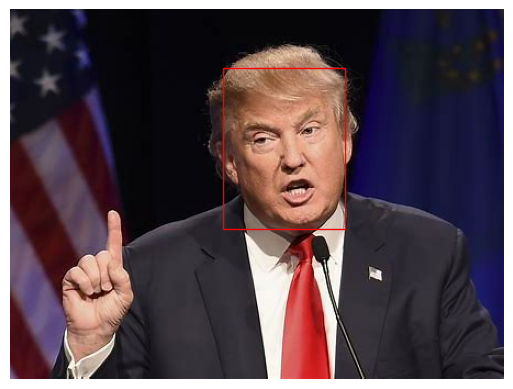

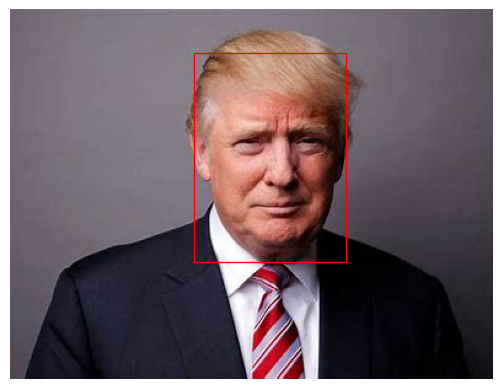

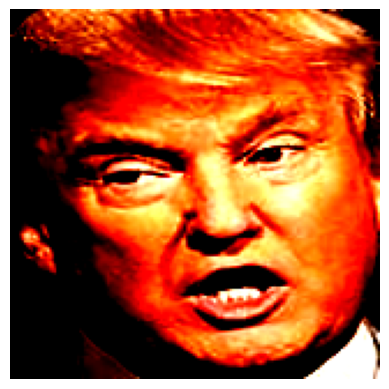

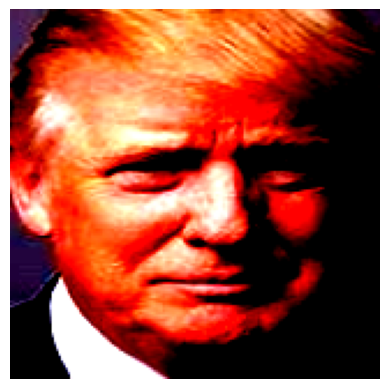

<Figure size 640x480 with 0 Axes>

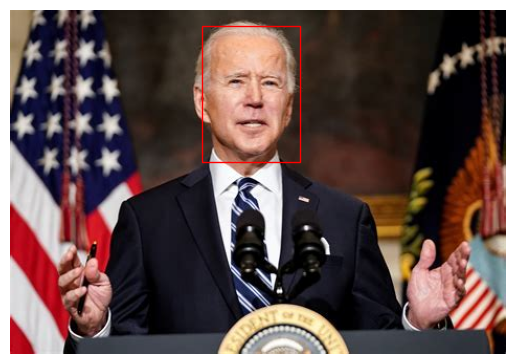

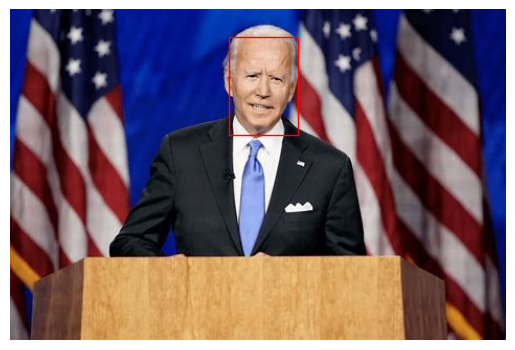

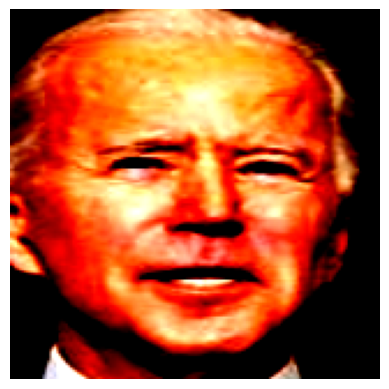

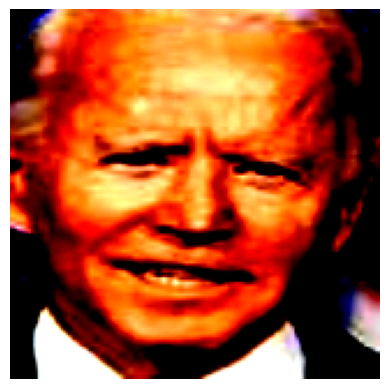

dist between same person 1 = 0.94957364
dist between same person 2 = 0.6818493
dist between different images 1 = 1.1226908
dist between different images 2 = 1.090082


In [48]:
import tensorflow as tf
import numpy as np
import cv2
mtcnn = MTCNN()

path = "c1.jpg"
c1 = read_image(path)
pre_c_1, box1 = detect_and_crop(mtcnn, c1)
c_1_f = pre_process(pre_c_1)
c_1_f = np.clip(c_1_f, 0, 1)


path = "c2.jpg"
c2 = read_image(path)
pre_c2_1, box2 = detect_and_crop(mtcnn, c2)
c_2_f = pre_process(pre_c2_1)
c_2_f = np.clip(c_2_f, 0, 1)


path = "b1.jpg"
b1 = read_image(path)
pre_b_1, box3 = detect_and_crop(mtcnn, b1)
b_1_f = pre_process(pre_b_1)
b_1_f = np.clip(b_1_f, 0, 1)


path = "b2.jpg"
b2 = read_image(path)
pre_b_2, box4 = detect_and_crop(mtcnn, b2)
b_2_f = pre_process(pre_b_2)
b_2_f = np.clip(b_2_f, 0, 1)


show_bounding_box(c1, box1)
show_bounding_box(c2, box2)
plt.imshow(c_1_f)
plt.axis('off')
plt.figure()
plt.imshow(c_2_f)
plt.axis('off')
plt.figure()


show_bounding_box(b1, box3)
show_bounding_box(b2, box4)
plt.imshow(b_1_f)
plt.axis('off')
plt.figure()
plt.imshow(b_2_f)
plt.axis('off')


plt.show()


tfl_file = "./code/inception_model.tflite"
interpreter = tf.lite.Interpreter(model_path=tfl_file)
interpreter.allocate_tensors()
out1 = run_model(interpreter, c_1_f)
out2 = run_model(interpreter, c_2_f)
out3 = run_model(interpreter, b_1_f)
out4 = run_model(interpreter, b_2_f)
print("dist between same person 1 = " + str(euclidean_distance(out1, out2)))
print("dist between same person 2 = " + str(euclidean_distance(out3, out4)))
print("dist between different images 1 = " + str(euclidean_distance(out1, out3)))
print("dist between different images 2 = " + str(euclidean_distance(out2, out4)))

In [49]:
# process the second image of the first person

# 1. Read the image
# 2. Detect and Crop
# 3. Proprocess
# 4. Run the model

# process the image of the second person

# Do the comparison of the distance
import tensorflow as tf
import numpy as np
import cv2









## Report Requirements & Grading (10 pts)
You need to turn in a report and the code. You may turn in a separately-written report, but **in general, we recommend that you directly use the provided Jupyter Notebook and turn it in as your report.** For the first half of Part III, you don't need to implement all the code in the notebook, but you can run the load model step in the notebooks to demonstrate the result.

### Part 1: (2 pts)
* Show the command/code and output for getting the following (0.5 points each):
    1. The CPU spec
    2. The network configuration
    3. The TensorFlow checks (version, GPU, etc.)
* You can make screenshots of both the command/code and the resulting output or paste them directly into the report or the notebook.
  
### Part 2: (4 pts)
* For each of the steps, briefly explain your approach and include the key outputs.
* Show the training and testing accuracy of your model. For full credit, the testing accuracy should be over 85% and training accuracy should be over 90%. (2 Points)
* Show the plots of train and validation loss and accuracy, similar to the ones shown before. (1 Point)
* Show the accuracy and inference time of the TFLite models quantized with the two methods with and without the USB accelerator. Compare and comment on what you observed in the report. There might be no significant improvements in terms of performance, but you should try to understand and explain why in your report. (1 Point)
  
### Part 3: (4 pts)
* For each of the steps, briefly explain your approach and include the key outputs.
* Show the output of loading weights for your model to confirm that your model is correctly implemented. You can get partial credit if you cannot load the model correctly. (2 Points)
* Show the bounding box of the face detected by MTCNN in the captured image, as described in the 'Face Detection' section of Part III. (1 Point)
* Report the distances between pairs of pictures, picked from 4 pictures: 2 of yourself and 2 of other people (6 pairs in total). Also, show all 4 pictures in your report. (1 Point)

### Notes: 
* Besides the above requirements, your report should also include the following details: 
  * Your full name and your NetID.
  * The difficulties/bugs you encountered and how you solved them
  * What you learned from this lab
* Your report should cover all the required information, but please keep your report clean and concise.
* Please add references to your report if you referred to any resources when you work on your lab.
* Please submit your **report** to Canvas
